***Imports***

In [1]:
import pathlib
import PIL
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy
import torch.nn as nn
from focal_loss.focal_loss import FocalLoss
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle5 as pickle
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


***Paths***

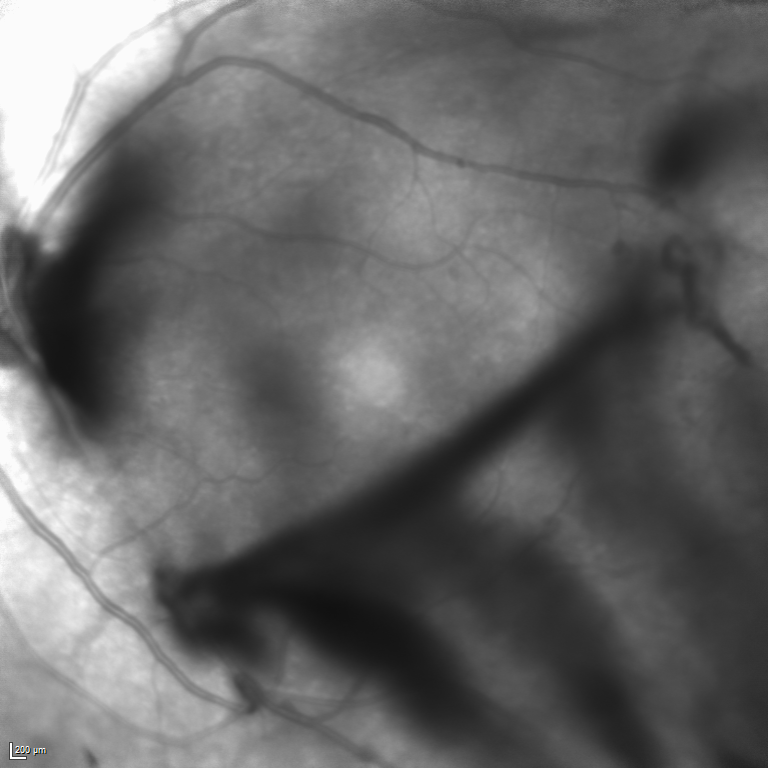

In [2]:
currDir = os.getcwd()
data_root = os.path.join(currDir, "OLIVES/Prime_FULL/")
annot_train_prime = os.path.join(currDir, "df_prime_train.csv")
annot_test_prime = os.path.join(currDir, "df_prime_test.csv")
testPath = os.path.join(data_root, "Prime_FULL/02-046/W104/OS/fundus_W104.tif")
PIL.Image.open(testPath)

***Implement Data loader***

In [3]:
LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])
    
class OCTDataset(Dataset):
    def __init__(self, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(annot_train_prime)
        elif subset == 'test':
            self.annot = pd.read_csv(annot_test_prime)
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self._labels)         



trainset = OCTDataset('train', transform=transform)
testset = OCTDataset('test', transform=transform)

***Test getitem function***

In [4]:
img, target = trainset.__getitem__(0)
print(img.shape)
print(target)
trainSize = 24252
testSize = 7987

torch.Size([1, 224, 224])
2


***Create first CNN Model***

In [17]:

class MyCNN(torch.nn.Module):
  def __init__(self):
    """Inititalizes the various layers in the network"""
    super(MyCNN, self).__init__()
    self.features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),
        torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),
        torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),
    )
    
    self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
    
    self.classifier = torch.nn.Sequential(
        #torch.nn.Dropout(.2),
        torch.nn.Linear(256 * 6 * 6, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(.2),
        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(.2),
        torch.nn.Linear(4096, 3),
        torch.nn.Softmax(dim=1)
    )

  def forward(self, x):

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)

    return x

***Params and Dataloader***

In [18]:
num_epochs = 20
learning_rate = 0.0001
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 1

trainingLoader = DataLoader(dataset=trainset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validationLoader = DataLoader(dataset=testset, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

***Instantiate and Run model***

In [19]:
model = MyCNN().to(device)
weights = torch.FloatTensor([1.0,3.0,1.0])
criterion = FocalLoss(gamma=4, weights=weights)
#criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [20]:
def check_accuracy(loader, model):
    if loader == trainingLoader:
        print("Checking accuracy on training data ")
    else:
        print("Checking accuracy on validation data ")

    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)

            predictions = torch.tensor([np.argmax(i.cpu()) for i in scores])
            #print(predictions)
            num_correct += (predictions == y.cpu()).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}\n"

In [21]:
#Training phase
#loop through epochs


trainingLosses = []
validationLosses = []
trainingAccuracies = []
validationAccuracies = []

for epoch in range(num_epochs):
    print(f"starting {epoch}/{num_epochs}")
    model.train()
    trainLoss = 0
    valLoss = 0
    numBatches = 0
    
    for iteration, (x, y) in enumerate(trainingLoader):
      optimizer.zero_grad()
      x = x.to(device = device)
      y = y.to(device = device)

      out = model(x.type(torch.cuda.FloatTensor))

      loss = criterion(out.cpu(), y.type(torch.LongTensor))
      #loss = criterion(out, y.type(torch.cuda.LongTensor))
      trainLoss += loss.item() 
        
      loss.backward()
      optimizer.step()
      numBatches += 1
      #print('Epoch : {} | Training Loss : {:0.4f}'.format(epoch, loss.item())
    
    trainingLosses.append(trainLoss/numBatches)
    numBatches = 0
    
    for x,y in validationLoader:
        x = x.to(device)
        y = y.to(device)
        out = model(x.type(torch.cuda.FloatTensor))
        loss = criterion(out.cpu(), y.type(torch.LongTensor))
        valLoss += loss.item()
        numBatches += 1
        
    
        
    validationLosses.append(valLoss/numBatches)
    trainingAccuracies.append(check_accuracy(trainingLoader, model))
    validationAccuracies.append(check_accuracy(validationLoader, model))
    print(f"Completed epoch {epoch}")


starting 0/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 0
starting 1/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 1
starting 2/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 2
starting 3/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 3
starting 4/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 4
starting 5/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 5
starting 6/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 6
starting 7/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 7
starting 8/20
Checking accuracy on training data 
Checking accuracy on validation data 
Completed epoch 8
starting 9/20
Checking accuracy on training da

***Testing Phase***

In [10]:
#Testing phase
accuracy = check_accuracy(validationLoader, model)
print(accuracy)

Checking accuracy on validation data 
45.04



In [11]:
#Testing phase
accuracyTrain = check_accuracy(trainingLoader, model)
print(accuracyTrain)

Checking accuracy on training data 
77.92



In [12]:
pickle_out = open(os.path.join(currDir, "cnn.pickle"), "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

***Loss and Accuracy Graphs***

['50.72\n', '48.63\n', '51.06\n', '44.84\n', '46.18\n', '49.76\n', '48.53\n', '49.07\n', '47.31\n', '46.75\n', '46.60\n', '45.82\n', '44.02\n', '42.09\n', '42.54\n', '40.22\n', '44.26\n', '42.53\n', '40.40\n', '42.93\n']
['61.53\n', '61.71\n', '68.41\n', '73.51\n', '73.16\n', '77.25\n', '77.06\n', '84.85\n', '84.56\n', '88.01\n', '88.58\n', '89.04\n', '94.86\n', '94.71\n', '92.02\n', '94.89\n', '92.31\n', '97.37\n', '97.62\n', '95.90\n']


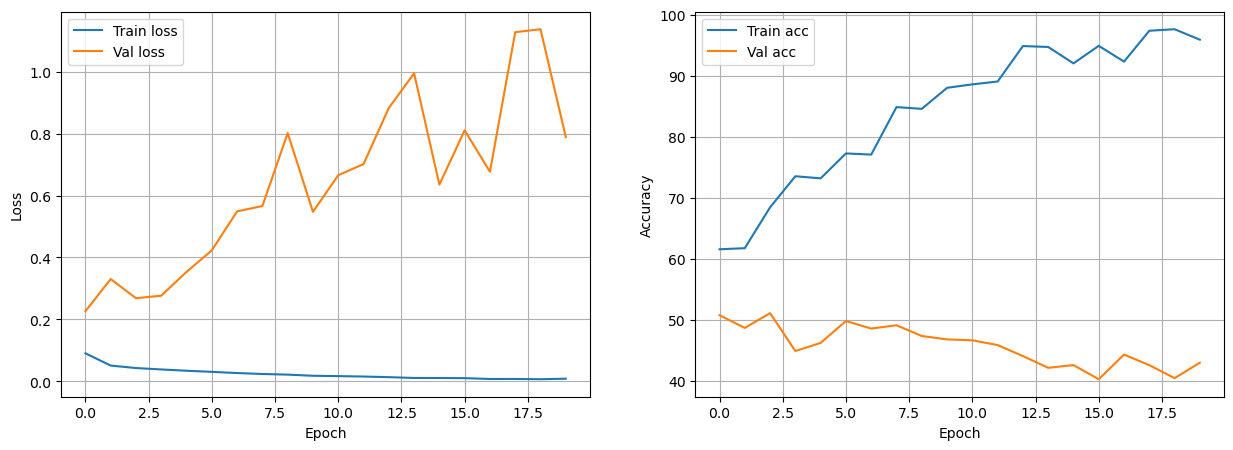

In [22]:
#validation and training loss graphs
print(validationAccuracies)
print(trainingAccuracies)

for i in range(len(validationAccuracies)):
    validationAccuracies[i] = float(validationAccuracies[i])
    trainingAccuracies[i] = float(trainingAccuracies[i])
    
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(trainingLosses,label="Train loss")
ax[0].plot(validationLosses,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(trainingAccuracies,label="Train acc")
ax[1].plot(validationAccuracies,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

plt.savefig('lossGraphsCNNCrossEntropy5Dropout.png')


***Confusion Matrices***

In [23]:
#confusion matrix
from sklearn import metrics
trainingLoader2 = DataLoader(dataset=trainset, shuffle=shuffle, batch_size=1,num_workers=num_workers,pin_memory=pin_memory)
validationLoader2 = DataLoader(dataset=testset, shuffle=shuffle, batch_size=1,num_workers=num_workers,pin_memory=pin_memory)

actualVal = []
actualTrain = []
predictedVal = []
predictedTrain = []

with torch.no_grad():
    for x,y in trainingLoader2:
        x = x.to(device)
        actualTrain.append(y[0])
        scores = model(x) 
        p = np.argmax(scores.cpu())
        predictedTrain.append(p)
        
    for x,y in validationLoader2:
        x = x.to(device)
        actualVal.append(y[0])
        scores = model(x)
        p = np.argmax(scores.cpu())
        predictedVal.append(p)
        

confusionMatrixVal = metrics.confusion_matrix(actualVal, predictedVal)
confusionMatrixTrain = metrics.confusion_matrix(actualTrain, predictedTrain)
cm_displayVal = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrixVal, display_labels = [0, 1, 2])
cm_displayTrain = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrixTrain, display_labels = [0, 1, 2])



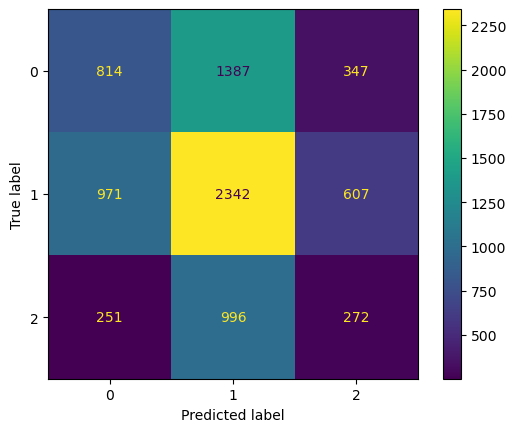

<Figure size 640x480 with 0 Axes>

In [24]:
cm_displayVal.plot()
plt.show()
plt.savefig('confustionMatVal.png')

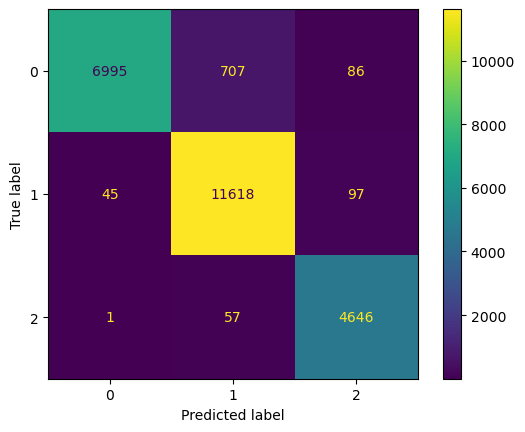

<Figure size 640x480 with 0 Axes>

In [25]:
cm_displayTrain.plot()
plt.show()
plt.savefig('confustionMatTrain.png')

In [27]:
from torchsummary import summary
summary(model, (1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          7,808
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          7,808
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]    

**Testing Existing Models**

In [18]:
def expand_grayscale_image(img):
    imgArr = np.array(img)
    imgArr = np.expand_dims(imgArr, -1)
    img3dArr = imgArr.repeat(3,axis=-1)
    return torch.tensor(img3dArr)

def batch_expand(x):
    ret = []
    for xsample in x:
        xsample  = xsample.reshape(224,224).numpy()
        xsample = torch.tensor([xsample, xsample, xsample])
        ret.append(xsample.numpy())
     
    ret = np.array(ret)
    #print(ret.shape)
    #img = Image.fromarray(255*ret[0][0].numpy())
    #img.show()
    return torch.tensor(ret)

def check_accuracy3D(loader, model):
    if loader == trainingLoader:
        print("Checking accuracy on training data ")
    else:
        print("Checking accuracy on validation data ")

    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = batch_expand(x)
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)

            predictions = torch.tensor([np.argmax(i.cpu()) for i in scores])
            #print(predictions)
            num_correct += (predictions == y.cpu()).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}\n"

In [19]:


from torchvision import models
modelResnet = models.resnet101(weights=False, num_classes=3)
#modelResnet.classifier[-1] = nn.Linear(modelResnet.classifier[-1].in_features, 3)
modelResnet = modelResnet.to(device)

#lossTesting = nn.CrossEntropyLoss()
weights = torch.FloatTensor([1.0,3.0,1.0])
criterion2 = FocalLoss(gamma=4, weights=weights)
optimizer = torch.optim.Adam(modelResnet.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  
  for i, (x, y) in enumerate(trainingLoader):
    modelResnet.train()
    
    optimizer.zero_grad()

    # extract input, obtain model output, loss, and backpropagate
    ##TODO
    #print(x.shape)
    x = batch_expand(x)
    #print(x.shape)
    x = x.to('cuda')
    y = y.to('cuda')
    modelResnet = modelResnet.to('cuda')
    out = modelResnet(x)
    loss_val = criterion2(out.type(torch.LongTensor).cpu(), y.type(torch.LongTensor))
    loss_val.backward()
    
    optimizer.step()

    print('Epoch: {} | Loss:{:0.6f}'.format(epoch, loss_val.item()))



/home/dams/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1835/3627361002.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  xsample = torch.tensor([xsample, xsample, xsample])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [69]:
#Testing phase
accuracy = check_accuracy3D(validationLoader, modelResnet)
print(accuracy)
accuracyTrain = check_accuracy3D(trainingLoader, modelResnet)
print(accuracyTrain)

Checking accuracy on validation data 
44.94

Checking accuracy on training data 
75.38

